In [1]:
import os
import glob
import pickle
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# Using a graph framework to visualize results

In [2]:
def onetoughjar(path2dic):
    with open(path2dic, 'rb') as pickle_file:
        try:
            while True:
                output = pickle.load(pickle_file)
        except EOFError:
            pass
    return(output)

In [3]:
dataPath = '/Users/gracer/Library/CloudStorage/OneDrive-UniversityofWyoming/0. Lab/M2AENAD Lab - Documents/RESEARCH/ABCD/Yana_SSIB_2024/tmp'

In [4]:
savedDict = onetoughjar(os.path.join(dataPath,'SSBABCDanalysisInt_11-26-2024_10-44-32'))

In [5]:
savedDict.keys()

dict_keys(['df', 'X', 'y', 'X_train', 'X_test', 'y_train', 'y_test', 'best_pipeline', 'X_reg', 'X_trainReg', 'X_testReg', 'y_trainReg', 'y_testReg', 'logistic', 'sigP', 'odds'])

In [6]:
interactions = list(savedDict['odds'].keys())

In [7]:
interactions

['rsfmri_c_ngd_cgc_ngd_cgc',
 'rsfmri_cor_ngd_df_scs_pllh',
 'rsfmri_cor_ngd_none_scs_cderh',
 'rsfmri_cor_ngd_sa_scs_thplh',
 'interview_age',
 'bmi_perc']

In [8]:
savedDict['odds']['rsfmri_c_ngd_cgc_ngd_cgc'].loc['int'][0]

3.78

In [9]:
df = savedDict['X']

In [10]:
df = df.join(savedDict['y'])

In [11]:
df.shape

(3700, 422)

In [18]:
brain = ['rsfmri_c_ngd_ad_ngd_cgc', 'rsfmri_c_ngd_ad_ngd_vs',
       'rsfmri_c_ngd_cgc_ngd_cgc', 'rsfmri_c_ngd_smh_ngd_smm',
       'rsfmri_c_ngd_sa_ngd_vta', 'rsfmri_cor_ngd_au_scs_aalh',
       'rsfmri_cor_ngd_au_scs_ptrh', 'rsfmri_cor_ngd_au_scs_vtdcrh',
       'rsfmri_cor_ngd_cerc_scs_cdelh', 'rsfmri_cor_ngd_cerc_scs_ptlh',
       'rsfmri_cor_ngd_cerc_scs_aglh', 'rsfmri_cor_ngd_cerc_scs_vtdclh',
       'rsfmri_cor_ngd_cerc_scs_hprh', 'rsfmri_cor_ngd_cerc_scs_agrh',
       'rsfmri_cor_ngd_cerc_scs_vtdcrh', 'rsfmri_cor_ngd_copa_scs_thplh',
       'rsfmri_cor_ngd_copa_scs_vtdclh', 'rsfmri_cor_ngd_copa_scs_plrh',
       'rsfmri_cor_ngd_df_scs_ptlh', 'rsfmri_cor_ngd_df_scs_pllh',
       'rsfmri_cor_ngd_df_scs_aalh', 'rsfmri_cor_ngd_none_scs_ptlh',
       'rsfmri_cor_ngd_none_scs_thprh', 'rsfmri_cor_ngd_none_scs_cderh',
       'rsfmri_cor_ngd_rst_scs_bs', 'rsfmri_cor_ngd_rst_scs_thprh',
       'rsfmri_cor_ngd_rst_scs_hprh', 'rsfmri_cor_ngd_rst_scs_vtdcrh',
       'rsfmri_cor_ngd_smh_scs_crcxlh', 'rsfmri_cor_ngd_smh_scs_pllh',
       'rsfmri_cor_ngd_smh_scs_cderh', 'rsfmri_cor_ngd_smh_scs_ptrh',
       'rsfmri_cor_ngd_smh_scs_hprh', 'rsfmri_cor_ngd_smh_scs_aarh',
       'rsfmri_cor_ngd_smm_scs_hplh', 'rsfmri_cor_ngd_smm_scs_aglh',
       'rsfmri_cor_ngd_smm_scs_thprh', 'rsfmri_cor_ngd_sa_scs_crcxlh',
       'rsfmri_cor_ngd_sa_scs_thplh', 'rsfmri_cor_ngd_vta_scs_hplh',
       'rsfmri_cor_ngd_vs_scs_hplh', 'rsfmri_cor_ngd_vs_scs_thprh',
       'rsfmri_cor_ngd_vs_scs_plrh', 'rsfmri_cor_ngd_vs_scs_hprh']

In [19]:
def graphList (cols, df):
    edges = []
    for x in cols:
        y = x.split('_')
        ROI1 = y[3]
        ROI2 = y[5]
        ser = (ROI1, ROI2, {"weight": df[x].mean(), "SD":df[x].std()})
        if x in interactions:
            ser[2].update({'odds':savedDict['odds']['%s'%x].loc['int'][0]})
        edges.append(ser)
    return(edges)

In [81]:
allEdgeList = graphList(brain, df)

In [121]:
allG = nx.Graph()
allG.add_edges_from(allEdgeList)


In [120]:
def nodeCleanUp(G, node1, node2, newnode):
    # Ensure nodes exist
    if not G.has_node(node1) or not G.has_node(node2):
        raise ValueError(f"One or both nodes ('{node1}', '{node2}') do not exist in the graph.")

    # Collect all neighbors and edge attributes, excluding the nodes being merged
    edges_with_attrs = {}

    # Handle self-loops
    self_loop_attrs = {}
    if G.has_edge(node1, node1):  # Self-loop on node1
        self_loop_attrs = G.get_edge_data(node1, node1)
    elif G.has_edge(node2, node2):  # Self-loop on node2
        self_loop_attrs = G.get_edge_data(node2, node2)

    # Process neighbors and edge attributes
    for neighbor in G.neighbors(node1):
        if neighbor not in [node1, node2]:  # Exclude merged nodes
            edges_with_attrs[neighbor] = G.get_edge_data(node1, neighbor)

    for neighbor in G.neighbors(node2):
        if neighbor not in [node1, node2]:  # Exclude merged nodes
            if neighbor in edges_with_attrs:
                # Merge edge attributes if neighbor exists in both
                for key, value in G.get_edge_data(node2, neighbor).items():
                    edges_with_attrs[neighbor][key] = value
            else:
                edges_with_attrs[neighbor] = G.get_edge_data(node2, neighbor)

    # Explicitly remove old nodes
    G.remove_nodes_from([node1, node2])

    # Debugging output
    print('Nodes after removal:', G.nodes())

    # Add the new node and recreate edges with attributes
    G.add_node(newnode)

    # Add edges to neighbors
    for neighbor, attrs in edges_with_attrs.items():
        G.add_edge(newnode, neighbor, **attrs)

    # Add self-loop if it existed
    if self_loop_attrs:
        G.add_edge(newnode, newnode, **self_loop_attrs)  # Self-loop preserved!

    return G


In [122]:
allG.nodes(data = True)

NodeDataView({'ad': {}, 'cgc': {}, 'vs': {}, 'smh': {}, 'smm': {}, 'sa': {}, 'vta': {}, 'au': {}, 'aalh': {}, 'ptrh': {}, 'vtdcrh': {}, 'cerc': {}, 'cdelh': {}, 'ptlh': {}, 'aglh': {}, 'vtdclh': {}, 'hprh': {}, 'agrh': {}, 'copa': {}, 'thplh': {}, 'plrh': {}, 'df': {}, 'pllh': {}, 'none': {}, 'thprh': {}, 'cderh': {}, 'rst': {}, 'bs': {}, 'crcxlh': {}, 'aarh': {}, 'hplh': {}})

In [126]:
allG.edges(data = True)

EdgeDataView([('vs', 'hplh', {'weight': -3.76486487286021e-10, 'SD': 0.10338391531803226}), ('vs', 'thprh', {'weight': -1.7822498181103648e-10, 'SD': 0.07430718302644605}), ('vs', 'plrh', {'weight': -4.2629218481746507e-10, 'SD': 0.087538620992617}), ('vs', 'hprh', {'weight': -4.5393133653812297e-10, 'SD': 0.12084807012022553}), ('vs', 'aud', {'weight': 4.2126004559286567e-10, 'SD': 0.06725088335851112}), ('smh', 'smm', {'weight': -1.837837830587969e-10, 'SD': 0.09575814327725679}), ('smh', 'crcxlh', {'weight': 1.5667202049221187e-10, 'SD': 0.13442476961172117}), ('smh', 'pllh', {'weight': -4.3801899358348523e-10, 'SD': 0.11350248022748617}), ('smh', 'cderh', {'weight': 3.1028414777099063e-10, 'SD': 0.1031351094110269}), ('smh', 'ptrh', {'weight': -3.685493052557759e-10, 'SD': 0.12284569325842405}), ('smh', 'hprh', {'weight': -4.24721695157834e-10, 'SD': 0.08486701066672293}), ('smh', 'aarh', {'weight': -2.6884587312938816e-10, 'SD': 0.10758679151041099}), ('smm', 'hplh', {'weight': 2.

In [124]:
allG = nodeCleanUp(allG, 'cgc', 'cerc', 'CO')

Nodes after removal: ['ad', 'vs', 'smh', 'smm', 'sa', 'vta', 'au', 'aalh', 'ptrh', 'vtdcrh', 'cdelh', 'ptlh', 'aglh', 'vtdclh', 'hprh', 'agrh', 'copa', 'thplh', 'plrh', 'df', 'pllh', 'none', 'thprh', 'cderh', 'rst', 'bs', 'crcxlh', 'aarh', 'hplh']


In [125]:
allG = nodeCleanUp(allG, 'ad', 'au', 'aud')

Nodes after removal: ['vs', 'smh', 'smm', 'sa', 'vta', 'aalh', 'ptrh', 'vtdcrh', 'cdelh', 'ptlh', 'aglh', 'vtdclh', 'hprh', 'agrh', 'copa', 'thplh', 'plrh', 'df', 'pllh', 'none', 'thprh', 'cderh', 'rst', 'bs', 'crcxlh', 'aarh', 'hplh', 'CO']


In [127]:
# Update the 'color' attribute for specific nodes
nx.set_node_attributes(allG, {'aud': {"color": "#FF00FF"}, 
                               'CO': {"color": "#8C0084"}, 
                               'vs': {"color": "#0000C6"}, 
                               'smh': {"color": "#00FFFF"}, 
                               'smm': {"color": "#FF7600"}, 
                               'sa': {"color": "#FE8EC7"}, 
                               'vta': {"color": "#008281"}, 
                                
                               'aalh': {"color": "#83008B"}, 
                               'ptrh': {"color": "#008400"}, 
                               'vtdcrh': {"color": "#38FF6D"}, 
                                
                               'cdelh': {"color": "#9CFF00"}, 
                               'ptlh': {"color": "#008400"}, 
                               'aglh': {"color": "#2C84B9"}, 
                               'vtdclh': {"color": "#38FF6D"}, 
                               'hprh': {"color": "#FB00ED"}, 
                               'agrh': {"color": "#2C84B9"}, 
                               'copa': {"color": "#A745FF"}, 
                               'thplh': {"color": "#FF767C"}, 
                               'plrh': {"color": "#38FFFF"}, 
                               'df': {"color": "#FF0000"}, 
                               'pllh': {"color": "#38FFFF"}, 
                               'none': {"color": "#FFFFFF"}, 
                               'thprh': {"color": "#FF767C"}, 
                               'cderh': {"color": "#9CFF00"}, 
                               'rst': {"color": "#FFFFC6"}, 
                               'bs': {"color": "#808000"}, 
                               'crcxlh': {"color": "#00CFA2"}, 
                               'aarh': {"color": "#83008B"}, 
                               'hplh': {"color": "#FB00ED"}
                              })


In [128]:
allG.nodes(data = True)

NodeDataView({'vs': {'color': '#0000C6'}, 'smh': {'color': '#00FFFF'}, 'smm': {'color': '#FF7600'}, 'sa': {'color': '#FE8EC7'}, 'vta': {'color': '#008281'}, 'aalh': {'color': '#83008B'}, 'ptrh': {'color': '#008400'}, 'vtdcrh': {'color': '#38FF6D'}, 'cdelh': {'color': '#9CFF00'}, 'ptlh': {'color': '#008400'}, 'aglh': {'color': '#2C84B9'}, 'vtdclh': {'color': '#38FF6D'}, 'hprh': {'color': '#FB00ED'}, 'agrh': {'color': '#2C84B9'}, 'copa': {'color': '#A745FF'}, 'thplh': {'color': '#FF767C'}, 'plrh': {'color': '#38FFFF'}, 'df': {'color': '#FF0000'}, 'pllh': {'color': '#38FFFF'}, 'none': {'color': '#FFFFFF'}, 'thprh': {'color': '#FF767C'}, 'cderh': {'color': '#9CFF00'}, 'rst': {'color': '#FFFFC6'}, 'bs': {'color': '#808000'}, 'crcxlh': {'color': '#00CFA2'}, 'aarh': {'color': '#83008B'}, 'hplh': {'color': '#FB00ED'}, 'CO': {'color': '#8C0084'}, 'aud': {'color': '#FF00FF'}})

In [129]:
def grapher(g):
    import matplotlib.pyplot as plt
    import networkx as nx
    import matplotlib as mpl
    
    # Set plot size
    plt.figure(figsize=(12, 8))  # Width=12, Height=8

    # Create a graph
    G = g

    # Extract edge attributes
    weights = nx.get_edge_attributes(G, 'weight')
    odds = nx.get_edge_attributes(G, 'odds')

    # Normalize edge weights for coloring
    edge_colors = [weights.get(edge, 0) for edge in G.edges]  # Default to 0 if no weight
    edge_colors2 = [odds.get(edge, 0) for edge in G.edges]    # Default to 0 if no odds
    
    # Extract the colors from node data
    node_colors = [data['color'] for _, data in G.nodes(data=True)]


    # Plot the graph
    pos = nx.circular_layout(G)  # Layout for better visualization

    # Draw the nodes and labels
    nx.draw_networkx_nodes(G, pos, node_size=500, node_color = node_colors)
    nx.draw_networkx_labels(G, pos)
    
    # Extract the colors from node data
    node_colors = [data['color'] for _, data in G.nodes(data=True)]


    # Draw edges based on odds
    nx.draw_networkx_edges(
        G, pos,
        edgelist=[edge for edge in G.edges if edge in odds],  # Only edges with odds
        edge_color=[odds[edge] for edge in G.edges if edge in odds],
        edge_cmap=plt.cm.Wistia,
        edge_vmin=min(edge_colors2),  # Explicitly normalize to odds range
        edge_vmax=max(edge_colors2),  # Explicitly normalize to odds range
        width=10,
    )
    
    # Draw edges based on weights
    nx.draw_networkx_edges(
        G, pos,
        edgelist=[edge for edge in weights],  # Only edges with weights
        edge_color=[weights[edge] for edge in weights],
        edge_cmap=plt.cm.cool,
        edge_vmin=min(edge_colors),  # Explicitly normalize to weight range
        edge_vmax=max(edge_colors),  # Explicitly normalize to weight range
        width=2,
    )

    # Add colorbar for weights
    sm_weights = mpl.cm.ScalarMappable(cmap=plt.cm.cool, norm=mpl.colors.Normalize(vmin=min(edge_colors), vmax=max(edge_colors)))
    sm_weights.set_array([])
    cbar_weights = plt.colorbar(sm_weights, label='Edge Weight', pad=0.01)
    
    # Add colorbar for odds
    sm_odds = mpl.cm.ScalarMappable(cmap=plt.cm.Wistia, norm=mpl.colors.Normalize(vmin=min(edge_colors2), vmax=max(edge_colors2)))
    sm_odds.set_array([])
    cbar_odds = plt.colorbar(sm_odds, label='Edge Odds', pad=0.1)

    plt.title("Graph with Edge Colors Based on Weights and Odds")
    plt.show()


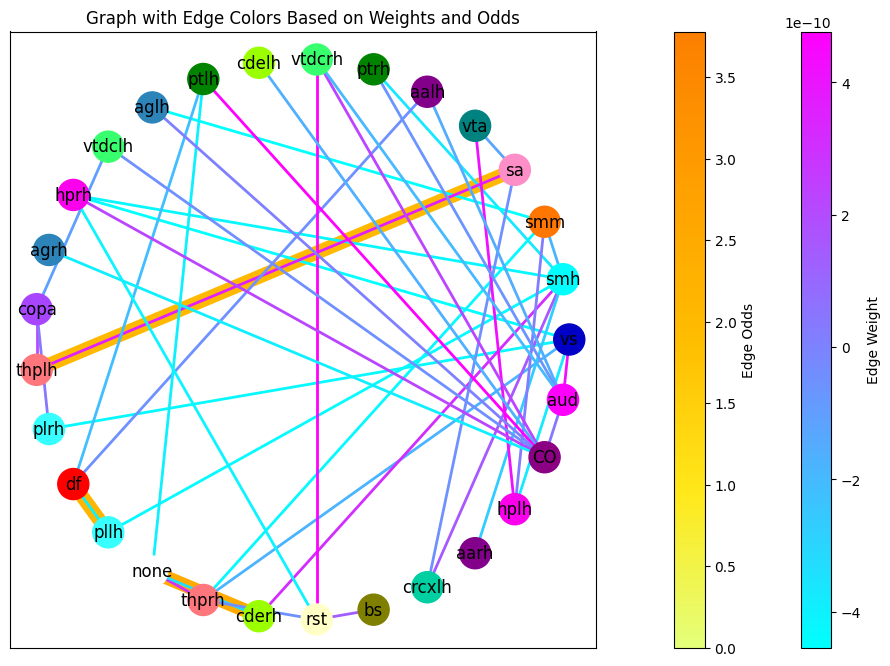

In [130]:
grapher(allG)

In [131]:
nx.degree(allG)

DegreeView({'vs': 5, 'smh': 7, 'smm': 4, 'sa': 3, 'vta': 2, 'aalh': 2, 'ptrh': 2, 'vtdcrh': 3, 'cdelh': 1, 'ptlh': 3, 'aglh': 2, 'vtdclh': 2, 'hprh': 4, 'agrh': 1, 'copa': 3, 'thplh': 2, 'plrh': 2, 'df': 3, 'pllh': 2, 'none': 3, 'thprh': 4, 'cderh': 2, 'rst': 4, 'bs': 1, 'crcxlh': 2, 'aarh': 1, 'hplh': 3, 'CO': 10, 'aud': 5})

# Making a plot of the odds ratios
https://github.com/ginoasuncion/data-visualizations/blob/main/notebooks/forest-plot-for-logistic-regression.ipynb

In [163]:
import  scipy.signal.signaltools

def _centered(arr, newsize):
    # Return the center newsize portion of the array.
    newsize = np.asarray(newsize)
    currsize = np.array(arr.shape)
    startind = (currsize - newsize) // 2
    endind = startind + newsize
    myslice = [slice(startind[k], endind[k]) for k in range(len(endind))]
    return arr[tuple(myslice)]

scipy.signal.signaltools._centered = _centered


In [164]:
import statsmodels.api as sm

In [157]:
y_testReg = savedDict['y_testReg']

In [158]:
X_testReg = savedDict['X_testReg']

In [167]:
X_testReg = X_testReg.drop('int', axis=1)


In [170]:
# Fit the multinomial logistic regression model
logit_model = sm.Logit(y_testReg, X_testReg)
result = logit_model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.428232
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:              ssb_group   No. Observations:                  232
Model:                          Logit   Df Residuals:                      183
Method:                           MLE   Df Model:                           48
Date:                Mon, 06 Jan 2025   Pseudo R-squ.:                  0.3819
Time:                        15:14:53   Log-Likelihood:                -99.350
converged:                       True   LL-Null:                       -160.73
Covariance Type:            nonrobust   LLR p-value:                 1.787e-08
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                             -0.0603      0.311     -0.194     

In [174]:
# Get coefficients
coefficients = result.params

# Calculate confidence intervals
conf = result.conf_int()
conf['coef'] = coefficients
conf.columns = ['Lower CI', 'Upper CI', 'Coefficient']


In [182]:
conf

,Lower CI,Upper CI,Coefficient
const,-0.669236,0.548552,-0.060342
rsfmri_c_ngd_ad_ngd_cgc,-10.150874,14.849267,2.349196
rsfmri_c_ngd_ad_ngd_vs,-7.004634,9.034482,1.014924
rsfmri_c_ngd_cgc_ngd_cgc,-12.451456,3.862409,-4.294523
rsfmri_c_ngd_smh_ngd_smm,-4.241264,8.342445,2.050590
rsfmri_c_ngd_sa_ngd_vta,-4.901662,8.994131,2.046234
rsfmri_cor_ngd_au_scs_aalh,-12.023168,2.471885,-4.775641
rsfmri_cor_ngd_au_scs_ptrh,-5.660263,9.407467,1.873602
rsfmri_cor_ngd_au_scs_vtdcrh,-4.977068,11.308649,3.165791
rsfmri_cor_ngd_cerc_scs_cdelh,-4.152246,12.953257,4.400505


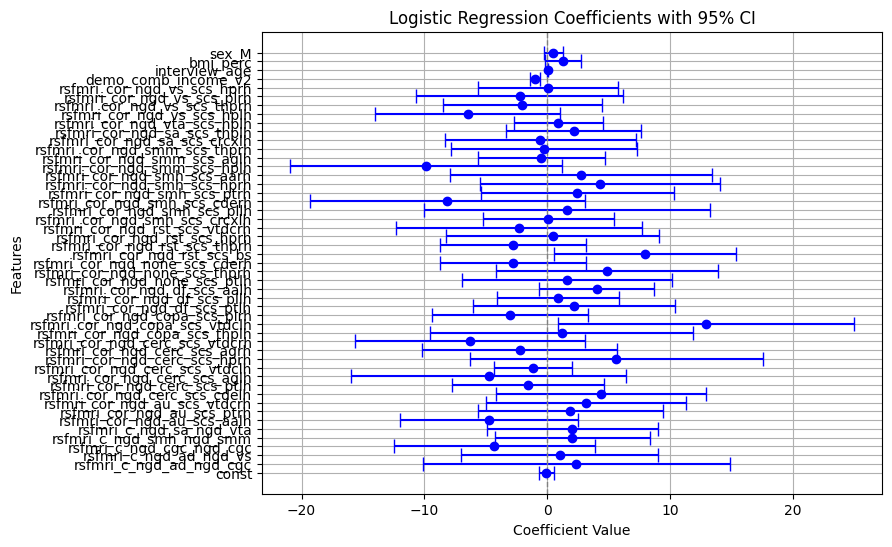

In [181]:
# Sort coefficients for easier visualization
#conf = conf.sort_values(by='Coefficient')

# Plot
plt.figure(figsize=(8, 6))
plt.errorbar(conf['Coefficient'], conf.index, 
             xerr=[conf['Coefficient'] - conf['Lower CI'], 
                   conf['Upper CI'] - conf['Coefficient']], 
             fmt='o', color='blue', capsize=5)

plt.axvline(x=0, linestyle='--', color='grey', linewidth=1)  # Add a vertical line at 0
plt.title('Logistic Regression Coefficients with 95% CI')
plt.xlabel('Coefficient Value')
plt.ylabel('Features')
plt.grid(True)
plt.show()


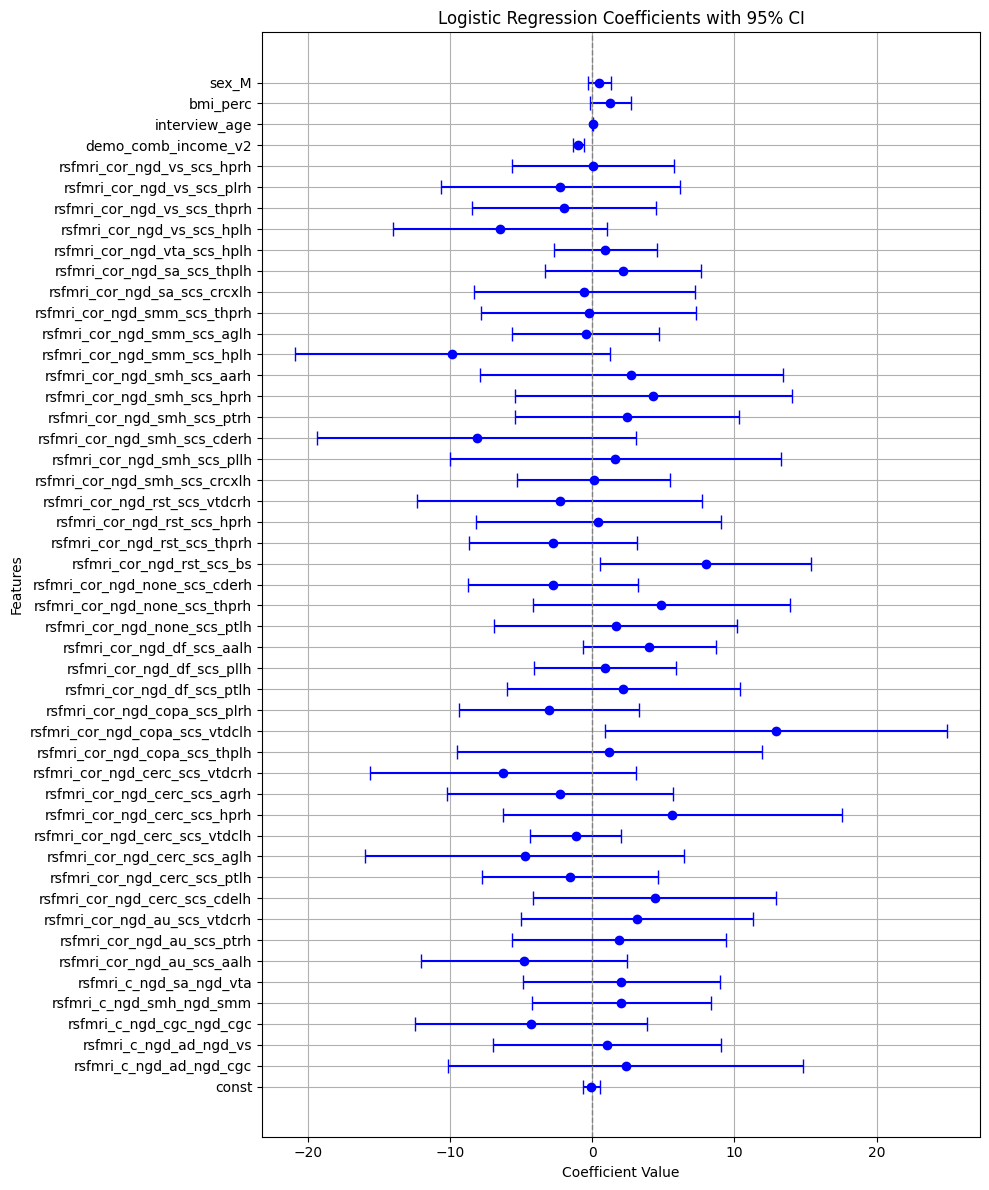

In [176]:
import matplotlib.pyplot as plt

# Adjust figure size for better spacing
plt.figure(figsize=(10, 12))  # Increase height for more spacing

# Plot coefficients with error bars
plt.errorbar(conf['Coefficient'], conf.index, 
             xerr=[conf['Coefficient'] - conf['Lower CI'], 
                   conf['Upper CI'] - conf['Coefficient']], 
             fmt='o', color='blue', capsize=5)

plt.axvline(x=0, linestyle='--', color='grey', linewidth=1)  # Add vertical line at 0
plt.title('Logistic Regression Coefficients with 95% CI')
plt.xlabel('Coefficient Value')
plt.ylabel('Features')

# Increase spacing between variables
plt.yticks(ticks=range(len(conf.index)), labels=conf.index, fontsize=10)  # Adjust font size

plt.grid(True)
plt.tight_layout()  # Ensures labels fit within the figure size
plt.show()


In [177]:
savedDict.keys()

dict_keys(['df', 'X', 'y', 'X_train', 'X_test', 'y_train', 'y_test', 'best_pipeline', 'X_reg', 'X_trainReg', 'X_testReg', 'y_trainReg', 'y_testReg', 'logistic', 'sigP', 'odds'])

In [178]:
savedDict['odds'].keys()

dict_keys(['rsfmri_c_ngd_cgc_ngd_cgc', 'rsfmri_cor_ngd_df_scs_pllh', 'rsfmri_cor_ngd_none_scs_cderh', 'rsfmri_cor_ngd_sa_scs_thplh', 'interview_age', 'bmi_perc'])

In [179]:
savedDict['odds']['interview_age']

,OR,2.5%,97.5%
rsfmri_c_ngd_ad_ngd_cgc,0.90,0.11,7.05
rsfmri_c_ngd_ad_ngd_vs,3.55,0.88,14.31
rsfmri_c_ngd_cgc_ngd_cgc,1.06,0.24,4.70
rsfmri_c_ngd_smh_ngd_smm,2.27,0.76,6.76
rsfmri_c_ngd_sa_ngd_vta,1.14,0.30,4.30
rsfmri_cor_ngd_au_scs_aalh,0.15,0.04,0.56
rsfmri_cor_ngd_au_scs_ptrh,1.55,0.39,6.08
rsfmri_cor_ngd_au_scs_vtdcrh,0.80,0.19,3.32
rsfmri_cor_ngd_cerc_scs_cdelh,0.07,0.01,0.34
rsfmri_cor_ngd_cerc_scs_ptlh,0.99,0.32,3.02


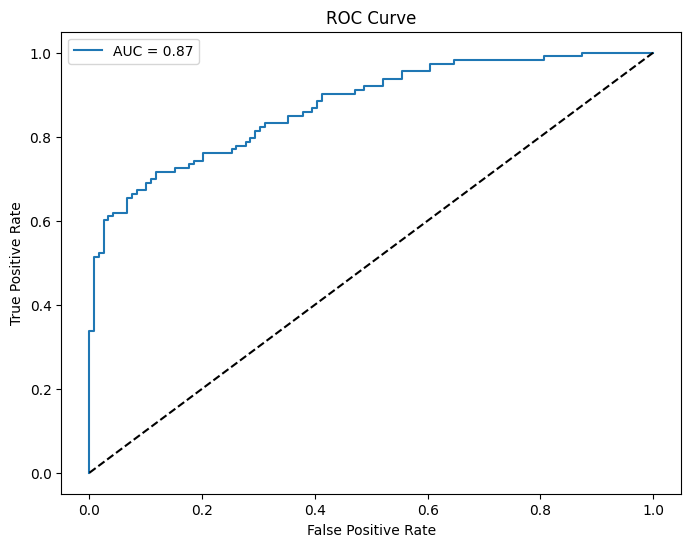

In [171]:
from sklearn.metrics import roc_curve, roc_auc_score

# Predicted probabilities
y_pred_prob = result.predict(X_testReg)

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_testReg, y_pred_prob)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y_testReg, y_pred_prob):.2f}')
plt.plot([0, 1], [0, 1], 'k--')  # Random classifier line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


In [133]:
savedDict.keys()

dict_keys(['df', 'X', 'y', 'X_train', 'X_test', 'y_train', 'y_test', 'best_pipeline', 'X_reg', 'X_trainReg', 'X_testReg', 'y_trainReg', 'y_testReg', 'logistic', 'sigP', 'odds'])